## RetrievalQA Chain

這是一個預先封裝好的 RAG（Retrieval-Augmented Generation）流程，用於：

1. 根據使用者問題，從向量資料庫中找出相關知識片段
2. 並將其與問題一起餵給 LLM 回答。

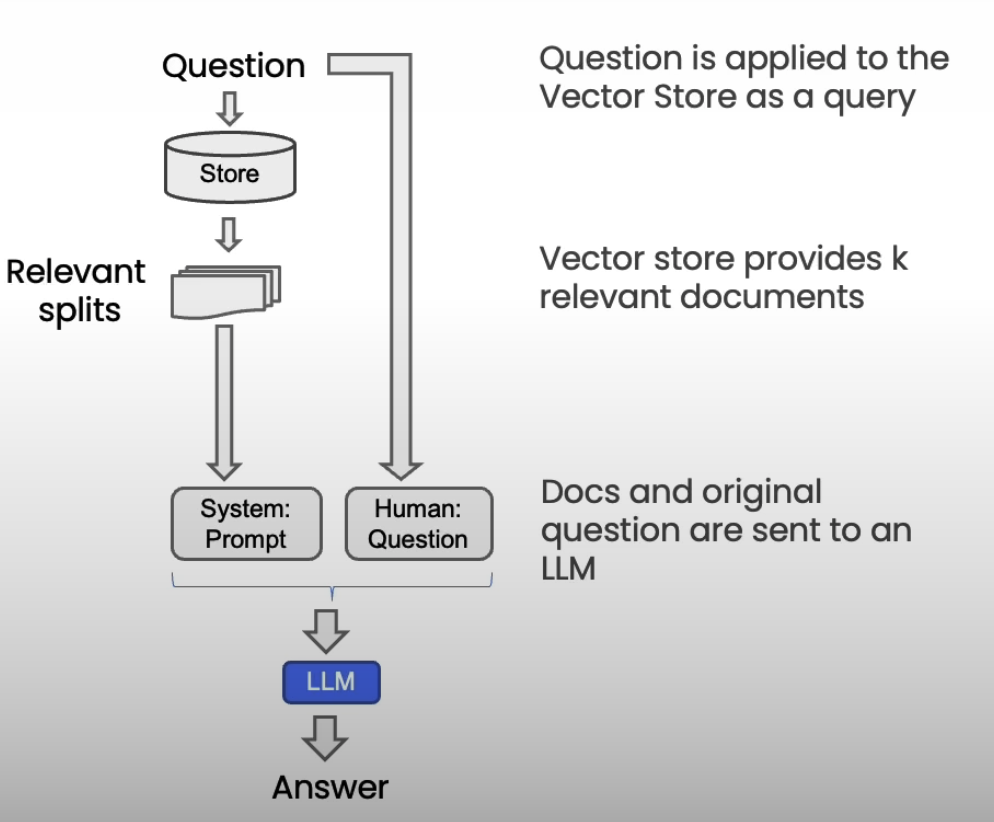

1. 使用者輸入問題（Question）
- 這個問題會作為**查詢（query）**傳給向量資料庫

2. 向量資料庫（Store）查詢

- 使用者的問題經過向量化 → 與資料庫中所有向量比較
- 取出 Top k 個最相關的 chunks（Relevant splits）

3. 生成 prompt 給 LLM

- 把這些 relevant chunks 與原始問題組合起來
- 包裝成 prompt（如：System Prompt + Human Prompt）

4. 餵給 LLM

- 使用語言模型生成最終答案

| 英文                  | 中文說明                            |
| ------------------- | ------------------------------- |
| **Store**           | 向量資料庫（如 FAISS、Chroma）           |
| **Relevant splits** | 擷取出來的相關文件片段（chunk）              |
| **System Prompt**   | 系統提示詞，例如指示模型「根據下列文件回答問題」        |
| **Human Question**  | 使用者真實提問內容                       |
| **LLM**             | 語言模型，如 OpenAI GPT、Ollama LLaMA2 |


補充 stuff 之外的三種 combine_documents_chain_type
1. Map_reduce
- 每段 chunk 各自送給 LLM 產生 partial answer（map）
- 將所有回答再整合成一個總結或完整回答（reduce）

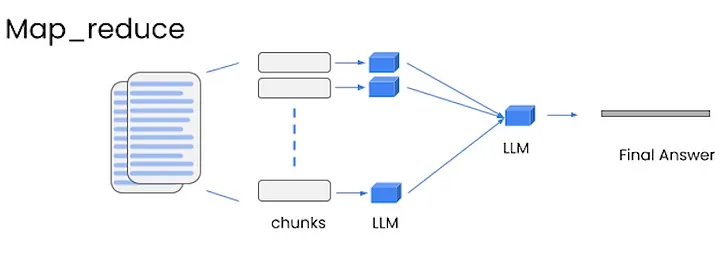

2. Refine
- 第一段 chunk 給 LLM 生成初步回答
- 每加入一段 chunk，就讓 LLM 根據該段「精煉/增強」原回答

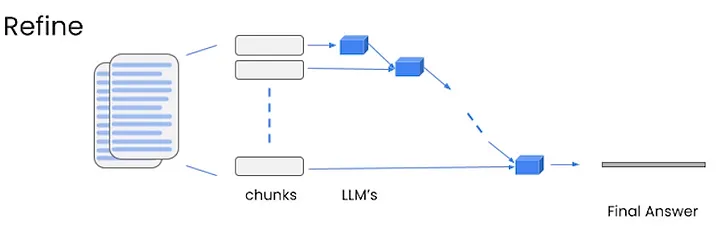

> 適合：需要保留前文邏輯或持續改進的回答

3. Map_rerank
- 每個 chunk 根據 query 給出一個回答與分數（relevance）
- 最後只選出 得分最高 的回答當作結果

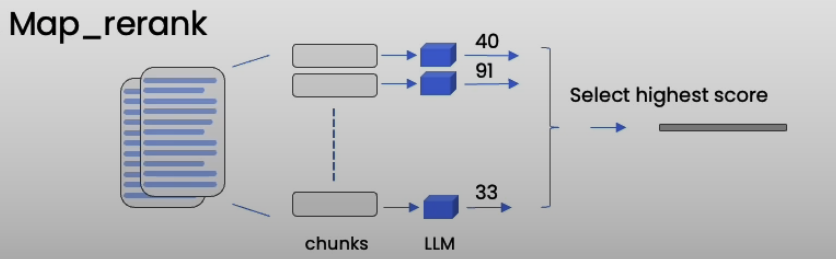

> 想選出最精準來源回應（非總結）

4. stuff
- 把所有檢索出來的 documents（chunks）原封不動「拼接」在一起
- 一起「塞進 prompt」裡面，和提問一起送給 LLM 生成答案

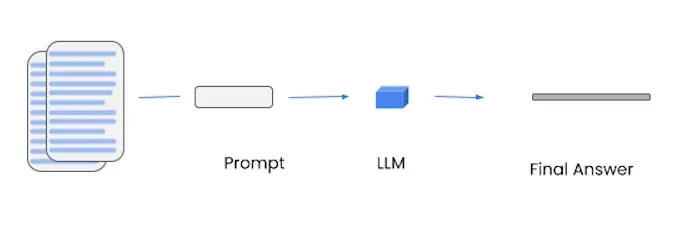


In [1]:
from langchain_ollama import OllamaEmbeddings
embedding = OllamaEmbeddings(model="llama3")
persist_directory = 'docs/chroma/'
from langchain_chroma import Chroma
vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

In [2]:
question = "CKAD Curriculum"
docs = vectordb.similarity_search(question,k=3)
print(docs)
print('\n')
len(docs)

[Document(id='e12bc899-754b-4314-8fb0-044d78a68b19', metadata={'moddate': '2025-04-08T08:47:51-04:00', 'title': '', 'total_pages': 3, 'author': '', 'subject': '', 'trapped': '', 'keywords': '', 'creationDate': "D:20250408084751-04'00'", 'modDate': "D:20250408084751-04'00'", 'file_path': './CKS_Curriculum_v1.32.pdf', 'creationdate': '2025-04-08T08:47:51-04:00', 'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'page': 1, 'format': 'PDF 1.4', 'source': './CKS_Curriculum_v1.32.pdf'}, page_content='Certified Kubernetes Security Specialist (CKS) Exam Curriculum\n2\nThis document provides the curriculum outline of the Knowledge, Skills and Abilities \nthat a Certified Kubernetes Security Specialist (CKS) can be expected to demonstrate.\nCKS Curriculum\n15% - Cluster Setup\n20% - Minimize Microservice \nVulnerabilities\n15% - Cluster Hardening\n20% - Supply Chain Security\n•\t Use Network security policies to restrict \ncluster level access\n•\t Use CIS bench

3

In [3]:
from langchain_ollama import OllamaLLM
llm = OllamaLLM(temperature=0.0, model="llama3")

In [4]:
from langchain.chains import create_retrieval_chain

In [5]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
prompt = ChatPromptTemplate.from_messages([
    ('system', """\
     Answer the user's questions in Chinese.
     \n\n
    {context}
     """),
    ('human', 'Question: {input}'),
])
"""
1.「拼接」成一段 →
2.「塞入」Prompt 的 {context} 區塊 →
3. 一起送進 LLM 處理
"""
question_answer_chain = create_stuff_documents_chain(llm, prompt)
qa_chain = create_retrieval_chain(
    vectordb.as_retriever(search_type = "mmr"),  question_answer_chain
)

In [6]:
result = qa_chain.invoke({'input': question})

In [7]:
result["answer"]

'CKAD 課程大綱：\n\n20% - 應用設計和構建\n20% - 應用部署\n15% - 應用可觀察性和維護\n\n其中包括了：\n\n* 定義、構建和修改容器映像\n* 選擇適合的工作負載資源（Deployment、DaemonSet、CronJob 等）\n* 理解多容器 Pod 設計模式（例如 sidecar、init 和其他）\n* 使用持久和臨時儲存體\n* 使用 Kubernetes基本元件實現常見部署策略（例如 blue/green 或 canary）\n* 理解 Deployments 和如何進行滾動更新\n* 使用 Helm 套件管理員部署已知套件\n* 理解 API depreciations\n* 實施探查和健康檢查\n* 使用內置 CLI 工具監控 Kubernetes 應用\n* 使用容器日誌\n* debug 在 Kubernetes 中\n* 表現基本的 NetworkPolicies 課程\n* 提供和排除應用程序訪問權限\n* 使用 Ingress 规則暴露應用程序'

### RetrievalQA chain types - map_reduce

acollapse_docs: 對 chunk 做「summary 縮減」的核心邏輯（map）

split_list_of_docs: 根據 token 數將文件切分為多個小段（partition）

這兩個組合起來就能完成：

1. 對每段 chunk 先做個別摘要（map）
2. 再將結果進行聚合總結（reduce）
3. 如果結果還是太長，就再遞迴 collapse（recursive）

```python
split_list_of_docs(
    docs: list[Document], # 待分割的 Document 物件列表
    length_func: Callable, # 計算文檔長度的函式，通常用於估算 token 數量
    token_max: int, # 每個子列表允許的最大累計長度（例如，token 數）
    **kwargs: Any # 傳遞給 length_func 的其他參數
) -> list[list[Document]]
```

split_list_of_docs 用於將一個 Document 物件的列表分割成多個子列表，每個子列表的累計長度不超過指定的最大值 token_max。這在處理大型文檔時特別有用，可以防止超出語言模型的上下文限制。

In [11]:
from typing import List
from langchain.chains.combine_documents.reduce import split_list_of_docs
from langchain_core.documents import Document

def length_function(docs: List[Document]):
    return sum(len(doc.page_content) for doc in docs)

docs = [
    Document(page_content="Kubernetes is a portable, extensible, open source platform for managing containerized workloads and services, that facilitates both declarative configuration and automation. It has a large, rapidly growing ecosystem. Kubernetes services, support, and tools are widely available."),
    Document(page_content="Service discovery and load balancing Kubernetes can expose a container using the DNS name or using their own IP address. If traffic to a container is high, Kubernetes is able to load balance and distribute the network traffic so that the deployment is stable."),
    Document(page_content="Storage orchestration Kubernetes allows you to automatically mount a storage system of your choice, such as local storages, public cloud providers, and more.")
]

split_docs = split_list_of_docs(docs, length_func=length_function, token_max=1000)
print(split_docs)

[[Document(metadata={}, page_content='Kubernetes is a portable, extensible, open source platform for managing containerized workloads and services, that facilitates both declarative configuration and automation. It has a large, rapidly growing ecosystem. Kubernetes services, support, and tools are widely available.'), Document(metadata={}, page_content='Service discovery and load balancing Kubernetes can expose a container using the DNS name or using their own IP address. If traffic to a container is high, Kubernetes is able to load balance and distribute the network traffic so that the deployment is stable.'), Document(metadata={}, page_content='Storage orchestration Kubernetes allows you to automatically mount a storage system of your choice, such as local storages, public cloud providers, and more.')]]


```python
async def acollapse_docs(
    docs: list[Document], # 要合併的 Document 物件列表
    combine_document_func: AsyncCombineDocsProtocol, # 處理合併邏輯的異步函式，接受 Document 列表並返回合併後的字串。
    **kwargs: Any # 傳遞給 combine_document_func 的其他參數。
) -> Document

```

acollapse_docs 是一個異步函式，用於將多個 Document 物件合併為一個，並透過指定的合併函式 combine_document_func 處理內容。這在需要將多個文檔摘要或壓縮為單一輸出時非常有用。

In [12]:
from langchain.chains.combine_documents.reduce import acollapse_docs
from langchain_core.documents import Document

async def combine_func(docs):
    combined_content = "\n".join(doc.page_content for doc in docs)
    return combined_content

docs = [
    Document(page_content="Kubernetes is a portable, extensible, open source platform for managing containerized workloads and services, that facilitates both declarative configuration and automation. It has a large, rapidly growing ecosystem. Kubernetes services, support, and tools are widely available."),
    Document(page_content="Service discovery and load balancing Kubernetes can expose a container using the DNS name or using their own IP address. If traffic to a container is high, Kubernetes is able to load balance and distribute the network traffic so that the deployment is stable."),
    Document(page_content="Storage orchestration Kubernetes allows you to automatically mount a storage system of your choice, such as local storages, public cloud providers, and more.")
]


collapsed_doc = await acollapse_docs(docs, combine_document_func=combine_func)
print(collapsed_doc)

page_content='Kubernetes is a portable, extensible, open source platform for managing containerized workloads and services, that facilitates both declarative configuration and automation. It has a large, rapidly growing ecosystem. Kubernetes services, support, and tools are widely available.
Service discovery and load balancing Kubernetes can expose a container using the DNS name or using their own IP address. If traffic to a container is high, Kubernetes is able to load balance and distribute the network traffic so that the deployment is stable.
Storage orchestration Kubernetes allows you to automatically mount a storage system of your choice, such as local storages, public cloud providers, and more.'


```python
%pip install langgraph 
```

In [13]:
from langchain_ollama import OllamaLLM
llm = OllamaLLM(temperature=0.0, model="llama3.2")

In [5]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter

loader = WebBaseLoader("https://argo-cd.readthedocs.io/en/stable/")
documents = loader.load()

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1500, chunk_overlap=10
)
split_docs = text_splitter.split_documents(documents)
print(f"Generated {len(split_docs)} documents.")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Generated 4 documents.


In [6]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


map_template = "Write a concise summary of the following: {context}."

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

map_prompt = ChatPromptTemplate([("human", map_template)])
reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

map_chain = map_prompt | llm | StrOutputParser()
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [7]:
from typing import List
from langchain_core.documents.base import Document

token_max = 1000

def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

In [8]:
import operator
from typing import Annotated, Literal, TypedDict
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)

class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]  # add key for collapsed summaries
    final_summary: str

class SummaryState(TypedDict):
    content: str


def generate_summary(state: SummaryState):
    response = map_chain.invoke(state["content"])
    return {"summaries": [response]}

def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }

def generate_final_summary(state: OverallState):
    response = reduce_chain.invoke(state["collapsed_summaries"])
    return {"final_summary": response}

"""
https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.reduce.split_list_of_docs.html#split-list-of-docs

https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.reduce.acollapse_docs.html#acollapse-docs
"""
def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(acollapse_docs(doc_list, reduce_chain.invoke))

    return {"collapsed_summaries": results}


def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("generate_final_summary", generate_final_summary)
graph.add_node("collapse_summaries", collapse_summaries)

graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)
app = graph.compile()

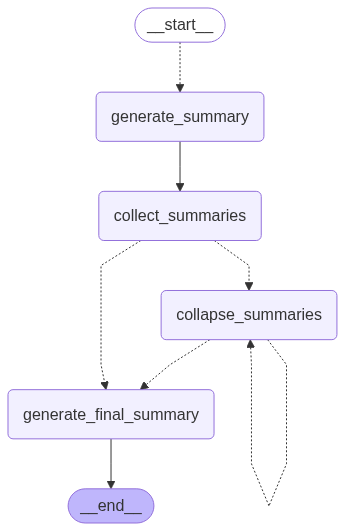

In [9]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [10]:
for step in app.stream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))
    print("\n")
    print(step)

['generate_summary']


{'generate_summary': {'summaries': ['Here is a concise summary of Argo CD:\n\nArgo CD is a declarative GitOps CD (Continuous Delivery) tool for Kubernetes that automates the deployment and management of applications in a Kubernetes cluster. It provides a simple, intuitive interface for defining application configurations and automatically applying them to the cluster.\n\nKey features include:\n\n* Declarative setup: define application configurations once and let Argo CD manage the deployment\n* High availability: supports dynamic cluster distribution and user management\n* Security: includes features like Snyk scans, verification of artifacts, and TLS configuration\n* Customization: allows for custom tooling, styles, and UI customization\n\nArgo CD is designed to simplify the process of deploying and managing applications in a Kubernetes environment, making it easier to adopt GitOps practices.']}}
['generate_summary']


{'generate_summary': {'summaries': ['Here i

### map_rerank
- 將文本切分成較小的文件；
- 對這些文件進行處理，此處的處理會產生一個分數；
- 根據分數對結果進行排序，並返回分數最高者。

In [51]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.prompts import ChatPromptTemplate
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

In [69]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model = "llama3.2",
    temperature = 0.1,
)

In [70]:
class AnswerWithScore(TypedDict):
    answer: str
    score: Annotated[int, ..., "Score from 1-10."]

In [71]:
prompt_template = "How to start Argo CD?\n\n" "Context: {context}"
prompt = ChatPromptTemplate.from_template(prompt_template)

In [72]:
map_chain = prompt | llm.with_structured_output(AnswerWithScore)

In [73]:
class State(TypedDict):
    contents: List[str]
    answers_with_scores: Annotated[list, operator.add]
    answer: str

In [74]:
class MapState(TypedDict):
    content: str

In [75]:
def map_analyses(state: State):
    return [
        Send("generate_analysis", {"content": content}) for content in state["contents"]
    ]

In [76]:
async def generate_analysis(state: MapState):
    response = await map_chain.ainvoke(state["content"])
    return {"answers_with_scores": [response]}

In [77]:
def pick_top_ranked(state: State):
    ranked_answers = sorted(
        state["answers_with_scores"], key=lambda x: -int(x["score"])
    )
    return {"answer": ranked_answers[0]}

In [78]:
graph = StateGraph(State)
graph.add_node("generate_analysis", generate_analysis)
graph.add_node("pick_top_ranked", pick_top_ranked)
graph.add_conditional_edges(START, map_analyses, ["generate_analysis"])
graph.add_edge("generate_analysis", "pick_top_ranked")
graph.add_edge("pick_top_ranked", END)
app = graph.compile()

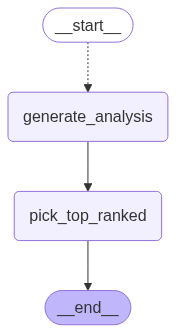

In [79]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [80]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://argo-cd.readthedocs.io/en/stable/")
documents = loader.load()

In [81]:
result = await app.ainvoke({"contents": [doc.page_content for doc in documents]})
result["answer"]

{'answer': 'kubectl create namespace argocd && kubectl apply -n argocd -f https://raw.githubusercontent.com/argoproj/argo-cd/stable/manifests/install.yaml',
 'score': 0}